# Preparations

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 6]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize

import datetime
import yfinance as yf

### Create time boundaries

In [5]:
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

In [7]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate target returns

### Load the stock data

In [10]:
stock_data = yf.download(portfolio, start_date, end_date, interval='1d')
stock_data = stock_data['Close']
stock_data = stock_data.reset_index()

[*********************100%***********************]  13 of 13 completed


### Calculate metrics

In [12]:
# Find the quarterly return for each period
selected = list(stock_data.columns[1:])
returns = stock_data[selected].pct_change()
# Find the expected returns 
expected_returns = returns.mean()
# Find the covariance 
cov = returns.cov()

### Calculate target portfolio

In [14]:
target_return = 0.17

In [15]:
min_stock_fraction = 1/(portfolio_len*2)
max_stock_fraction = 2/portfolio_len

bounds = tuple((min_stock_fraction, max_stock_fraction) for i in range(portfolio_len))

In [16]:
cons = (
    # Sum of weights must equate to 1
    {'type' : 'eq', 'fun' : lambda w : np.sum(w) - 1},
    # Difference between expected return and target must be equal to 0.
    {'type' : 'eq', 'fun' : lambda x : x.dot(expected_returns) * 250 - target_return})

In [17]:
def getPortReturn(weights):
    return np.dot(np.transpose(weights), expected_returns) * 250

In [18]:
results = minimize(fun=getPortReturn,
                   x0=current_weights, 
                   bounds=bounds,
                   constraints=cons)  
print(results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17000000007626423
       x: [ 1.538e-01  1.306e-01 ...  3.846e-02  8.633e-02]
     nit: 2
     jac: [ 3.290e-01  2.141e-01 ... -1.999e-02  1.295e-01]
    nfev: 28
    njev: 2


# Results

In [20]:
current_return = getPortReturn(current_weights)
current_volatility = np.sqrt(np.dot(np.transpose(current_weights), np.dot(cov, current_weights)))

In [21]:
target_weights = [float(round(x, 4)) for x in results['x']]

In [22]:
target_return = getPortReturn(target_weights)
target_volatility = np.sqrt(np.dot(np.transpose(target_weights), np.dot(cov, target_weights)))

In [23]:
current_portfolio = pd.DataFrame(current_weights, index=portfolio, columns=['Current weights'])
target_portfolio = pd.DataFrame(target_weights, index=portfolio, columns=['Target weights'])

portfolios = pd.concat([current_portfolio, target_portfolio], axis=1)

portfolios

,Current weights,Target weights
AAPL,0.1269,0.1538
ABBV,0.1082,0.1306
BAC,0.0473,0.0442
BTI,0.0762,0.0485
C,0.0441,0.0385
CMCSA,0.0627,0.0385
FDX,0.1069,0.1231
GPS,0.1006,0.1295
HPQ,0.0716,0.0916
INTC,0.0401,0.0385


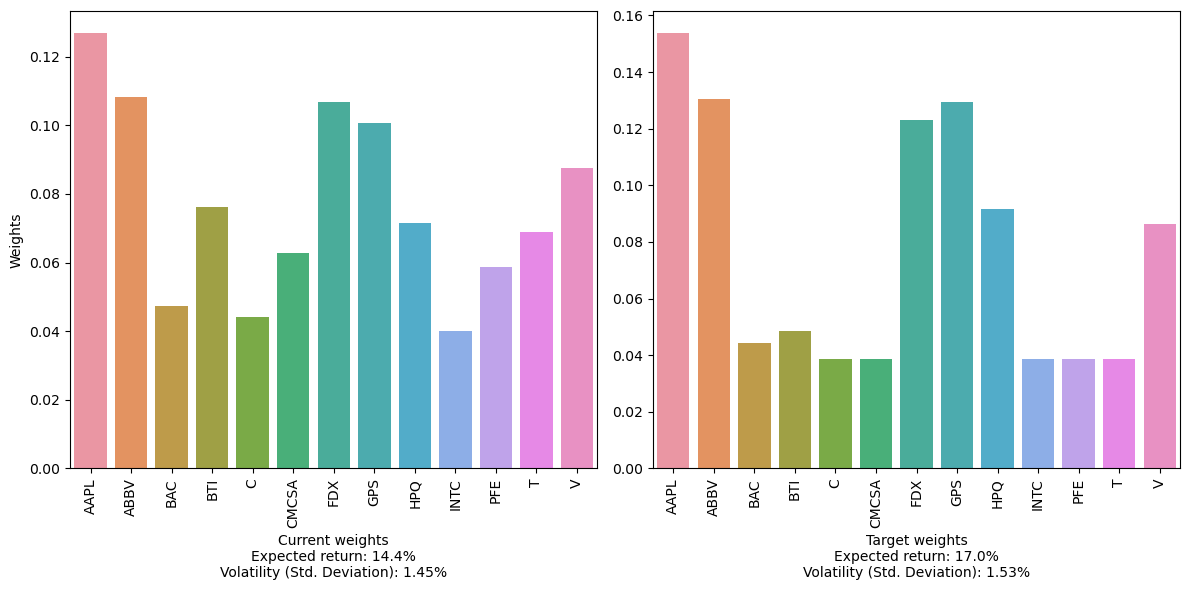

In [24]:
ax1 = plt.subplot(1,2,1)
sns.barplot(x=portfolios.index, y=portfolios['Current weights'])
plt.ylabel("Weights");
plt.xlabel(f"Current weights\nExpected return: {round(current_return*100,2)}%\nVolatility (Std. Deviation): {round(current_volatility*100,2)}%");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(1,2,2)
sns.barplot(x=portfolios.index, y=portfolios['Target weights'])
plt.ylabel("");
plt.xlabel(f"Target weights\nExpected return: {round(target_return*100,2)}%\nVolatility (Std. Deviation): {round(target_volatility*100,2)}%");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()